- **Group ID:** [DB8-PG010]
- **Sumber Dataset:** https://drive.google.com/file/d/1By-Y0rcgMuKX8EOLJ790uwJ8ggsVNZ7e/view

## Import Semua Packages/Library yang Digunakan

In [1]:
import os, csv, random, warnings
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns # Import seaborn

In [2]:
# Mencetak versi TensorFlow yang sedang digunakan
print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.19.0


## Data Preparation

### Data Loading

In [3]:
file_id = "1By-Y0rcgMuKX8EOLJ790uwJ8ggsVNZ7e"
url = f"https://drive.google.com/uc?export=download&id={file_id}"
df = pd.read_csv(url, low_memory=False)

In [4]:
df_paddy = df[df['Crop Type'] == 'Paddy'].copy()
print(f"Bentuk data setelah filter 'Paddy': {df_paddy.shape}")

Bentuk data setelah filter 'Paddy': (85754, 10)


In [5]:
df_paddy.head()

,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
4,4,35,58,43,Red,Paddy,37,2,16,DAP
6,6,27,62,53,Sandy,Paddy,26,15,22,28-28
14,14,36,60,44,Sandy,Paddy,15,3,30,20-20
20,20,26,63,37,Sandy,Paddy,39,1,28,Urea
24,24,30,55,53,Sandy,Paddy,20,19,12,28-28


In [6]:
df_paddy = df_paddy.drop(['id', 'Crop Type'], axis=1)
# df_paddy = df_paddy.drop(['id', 'Humidity', 'Moisture', 'Crop Type', 'Nitrogen', 'Potassium'], axis=1)
print("\nKolom yang digunakan untuk model:")
print(df_paddy.columns)


Kolom yang digunakan untuk model:
Index(['Temparature', 'Humidity', 'Moisture', 'Soil Type', 'Nitrogen',
       'Potassium', 'Phosphorous', 'Fertilizer Name'],
      dtype='object')


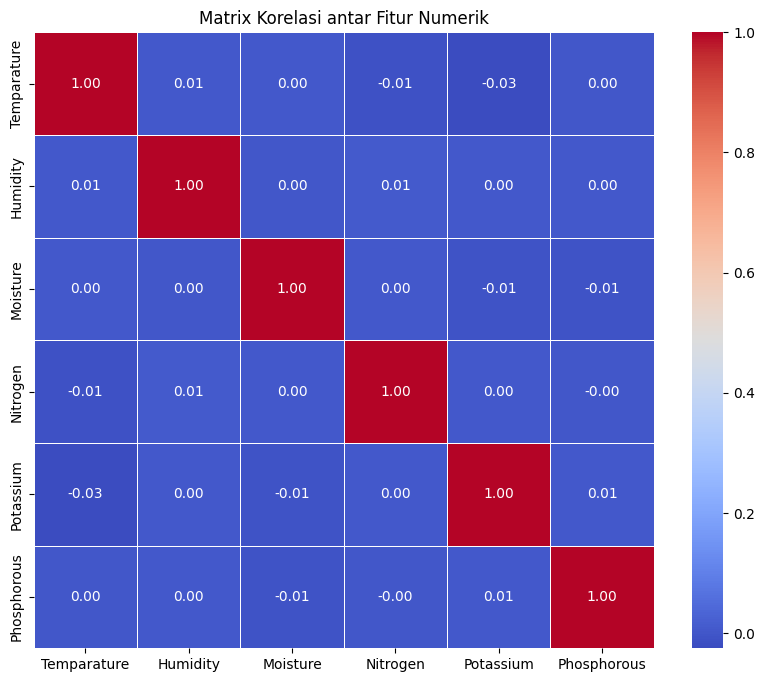

In [7]:
# Visualisasi Matrix Correlation antar Fitur Numerik
# Pilih hanya kolom numerik untuk perhitungan korelasi
df_numeric = df_paddy.select_dtypes(include=np.number)

# Hitung matrix korelasi
correlation_matrix = df_numeric.corr()

# Tampilkan heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matrix Korelasi antar Fitur Numerik')
plt.show()

In [8]:
df_paddy.head()

,Temparature,Humidity,Moisture,Soil Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
4,35,58,43,Red,37,2,16,DAP
6,27,62,53,Sandy,26,15,22,28-28
14,36,60,44,Sandy,15,3,30,20-20
20,26,63,37,Sandy,39,1,28,Urea
24,30,55,53,Sandy,20,19,12,28-28


In [9]:
df_paddy.describe()

,Temparature,Humidity,Moisture,Nitrogen,Potassium,Phosphorous
count,85754.000000,85754.000000,85754.000000,85754.000000,85754.000000,85754.000000
mean,31.527101,61.021713,45.422977,22.915398,9.501119,21.201040
std,4.065536,6.647491,11.907852,11.332435,5.775685,12.365459
min,25.000000,50.000000,25.000000,4.000000,0.000000,0.000000
25%,28.000000,55.000000,35.000000,13.000000,4.000000,11.000000
50%,32.000000,61.000000,45.000000,23.000000,9.000000,21.000000
75%,35.000000,67.000000,56.000000,33.000000,15.000000,32.000000
max,38.000000,72.000000,65.000000,42.000000,19.000000,42.000000


In [10]:
df_paddy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85754 entries, 4 to 749990
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Temparature      85754 non-null  int64 
 1   Humidity         85754 non-null  int64 
 2   Moisture         85754 non-null  int64 
 3   Soil Type        85754 non-null  object
 4   Nitrogen         85754 non-null  int64 
 5   Potassium        85754 non-null  int64 
 6   Phosphorous      85754 non-null  int64 
 7   Fertilizer Name  85754 non-null  object
dtypes: int64(6), object(2)
memory usage: 5.9+ MB


In [11]:
print(f"\nJumlah nilai null per kolom:\n{df_paddy.isnull().sum()}")


Jumlah nilai null per kolom:
Temparature        0
Humidity           0
Moisture           0
Soil Type          0
Nitrogen           0
Potassium          0
Phosphorous        0
Fertilizer Name    0
dtype: int64


In [12]:
print(f"\nJumlah nilai duplicated per kolom:\n{df_paddy.duplicated().sum()}")


Jumlah nilai duplicated per kolom:
0


### Data Preprocessing

#### Pre-Processing

In [13]:
target_column = 'Fertilizer Name'
X = df_paddy.drop(target_column, axis=1)
y = df_paddy[target_column]

In [14]:
# Identifikasi kolom numerik dan kategorikal
numerical_features = ['Temparature', 'Humidity', 'Moisture', 'Nitrogen', 'Potassium', 'Phosphorous']
# numerical_features = ['Temparature', 'Phosphorous']
categorical_features = ['Soil Type']

In [15]:
# --- Preprocessing Kolom Numerik ---
# Menggunakan StandardScaler, cocok untuk Deep Learning
scaler = StandardScaler()
X_numerical_scaled = scaler.fit_transform(X[numerical_features])
# Ubah kembali ke DataFrame agar mudah digabung
X_numerical_scaled_df = pd.DataFrame(X_numerical_scaled,
                                     columns=numerical_features,
                                     index=X.index)

In [16]:
# --- Preprocessing Kolom Kategorikal ---
# Menggunakan One-Hot Encoding
X_categorical_encoded = pd.get_dummies(X[categorical_features], drop_first=False)

In [17]:
# --- Gabungkan kembali Fitur ---
X_processed = pd.concat([X_numerical_scaled_df, X_categorical_encoded], axis=1)

In [18]:
print(f"\nBentuk data fitur (X) setelah preprocessing: {X_processed.shape}")
print("Contoh 5 baris data fitur (X) yang sudah diproses:")
print(X_processed.head())


Bentuk data fitur (X) setelah preprocessing: (85754, 11)
Contoh 5 baris data fitur (X) yang sudah diproses:
    Temparature  Humidity  Moisture  Nitrogen  Potassium  Phosphorous  \
4      0.854234 -0.454567 -0.203478  1.242865  -1.298749    -0.420613   
6     -1.113538  0.147167  0.636308  0.272194   0.952080     0.064613   
14     1.100206 -0.153700 -0.119500 -0.698477  -1.125608     0.711580   
20    -1.359509  0.297601 -0.707351  1.419350  -1.471889     0.549838   
24    -0.375623 -0.905868  0.636308 -0.257263   1.644642    -0.744096   

    Soil Type_Black  Soil Type_Clayey  Soil Type_Loamy  Soil Type_Red  \
4             False             False            False           True   
6             False             False            False          False   
14            False             False            False          False   
20            False             False            False          False   
24            False             False            False          False   

    Soil Type

In [19]:
# Preprocessing Target (y)
# Menggunakan LabelEncoder untuk mengubah nama pupuk (string) menjadi angka (integer)
label_encoder = LabelEncoder()
y_processed = label_encoder.fit_transform(y)

In [20]:
# Simpan jumlah kelas untuk output layer model
num_classes = len(label_encoder.classes_)
print(f"\nJumlah kelas pupuk (target): {num_classes}")
print(f"Nama kelas: {label_encoder.classes_}")


Jumlah kelas pupuk (target): 7
Nama kelas: ['10-26-26' '14-35-14' '17-17-17' '20-20' '28-28' 'DAP' 'Urea']


#### Split Dataset

In [21]:
# Split Data: 80% Training, 20% Validation
# stratify=y_processed penting agar proporsi kelas pupuk di train dan val set sama
X_train, X_val, y_train, y_val = train_test_split(
    X_processed,
    y_processed,
    test_size=0.2,
    random_state=42,
    stratify=y_processed
)

print(f"\nData Latih (Train): {X_train.shape}, {y_train.shape}")
print(f"Data Validasi (Val): {X_val.shape}, {y_val.shape}")


Data Latih (Train): (68603, 11), (68603,)
Data Validasi (Val): (17151, 11), (17151,)


In [22]:
# Simpan input shape untuk model
input_shape = (X_train.shape[1],)

## Modelling

In [23]:
# Bangun Arsitektur Model

model = Sequential(name="Fertilizer_Recommendation_Model")
model.add(Input(shape=input_shape, name="Input_Layer"))
model.add(Dense(128, activation='relu', name="Hidden_Layer_1"))
model.add(Dropout(0.4, name="Dropout_1")) # Dropout untuk mengurangi overfitting
model.add(Dense(64, activation='relu', name="Hidden_Layer_2"))
model.add(Dropout(0.2, name="Dropout_2"))
model.add(Dense(num_classes, activation='softmax', name="Output_Layer")) # Softmax untuk klasifikasi multi-kelas

In [24]:
# Compile Model

model.compile(
    optimizer='adam', # Optimizer yang umum dan efektif
    loss='sparse_categorical_crossentropy', # Cocok karena y_train adalah integer (bukan one-hot)
    metrics=['accuracy']
)

In [25]:
# Tampilkan ringkasan model

model.summary()

Model: "Fertilizer_Recommendation_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden_Layer_1 (Dense)          │ (None, 128)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_2 (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,247 (40.03 KB)

 Trainable params: 10,247 (40.03 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Siapkan Callback
# EarlyStopping untuk menghentikan training jika val_loss tidak membaik
# restore_best_weights=True akan mengembalikan bobot model ke epoch terbaik

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15, # Jumlah epoch tanpa perbaikan sebelum berhenti
    restore_best_weights=True,
    verbose=1
)

In [27]:
# Latih Model

print("\nMemulai pelatihan model...")
history = model.fit(
    X_train,
    y_train,
    epochs=100, # Jumlah epoch maksimal
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=2 # Tampilkan log per epoch
)

print("Pelatihan model selesai.")


Memulai pelatihan model...
Epoch 1/100
2144/2144 - 7s - 3ms/step - accuracy: 0.1536 - loss: 1.9476 - val_accuracy: 0.1587 - val_loss: 1.9423
Epoch 2/100
2144/2144 - 5s - 2ms/step - accuracy: 0.1587 - loss: 1.9431 - val_accuracy: 0.1550 - val_loss: 1.9420
Epoch 3/100
2144/2144 - 6s - 3ms/step - accuracy: 0.1607 - loss: 1.9422 - val_accuracy: 0.1614 - val_loss: 1.9415
Epoch 4/100
2144/2144 - 5s - 2ms/step - accuracy: 0.1607 - loss: 1.9419 - val_accuracy: 0.1592 - val_loss: 1.9412
Epoch 5/100
2144/2144 - 6s - 3ms/step - accuracy: 0.1616 - loss: 1.9414 - val_accuracy: 0.1589 - val_loss: 1.9413
Epoch 6/100
2144/2144 - 5s - 2ms/step - accuracy: 0.1630 - loss: 1.9411 - val_accuracy: 0.1605 - val_loss: 1.9414
Epoch 7/100
2144/2144 - 5s - 2ms/step - accuracy: 0.1615 - loss: 1.9411 - val_accuracy: 0.1598 - val_loss: 1.9409
Epoch 8/100
2144/2144 - 5s - 2ms/step - accuracy: 0.1641 - loss: 1.9402 - val_accuracy: 0.1603 - val_loss: 1.9407
Epoch 9/100
2144/2144 - 5s - 2ms/step - accuracy: 0.1634 - l

## Evaluasi dan Visualisasi

In [28]:
# Evaluasi Model pada Data Validasi

val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"\n--- Hasil Evaluasi Model ---")
print(f"Loss Validasi \t: {val_loss:.4f}")
print(f"Akurasi Validasi: {val_accuracy * 100:.2f}%")


--- Hasil Evaluasi Model ---
Loss Validasi 	: 1.9407
Akurasi Validasi: 16.03%


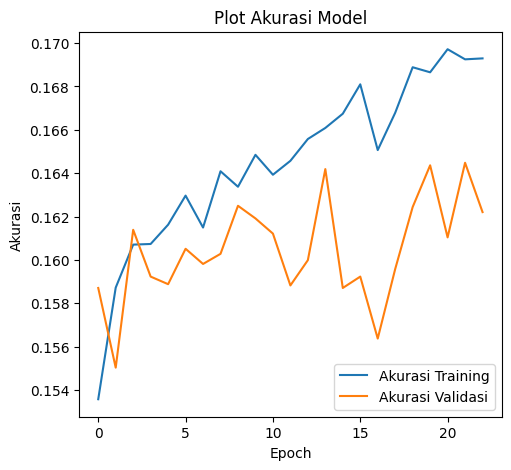

In [29]:
# Visualisasi Akurasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Akurasi Training')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.title('Plot Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend(loc='lower right')

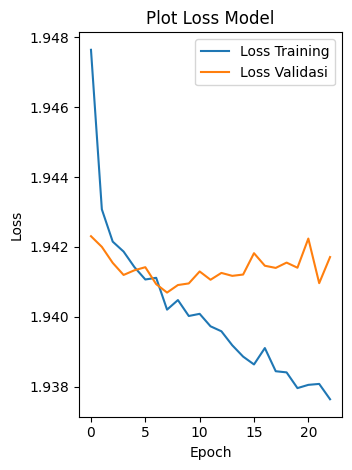

In [30]:
# Visualisasi Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Training')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.title('Plot Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [31]:
# Classification Report
# Lakukan prediksi pada data validasi
y_pred_probs = model.predict(X_val)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Tampilkan classification report
print("\n--- Classification Report ---")
print(classification_report(
    y_val,
    y_pred_classes,
    target_names=label_encoder.classes_
))

536/536 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

--- Classification Report ---
              precision    recall  f1-score   support

    10-26-26       0.16      0.34      0.22      2562
    14-35-14       0.18      0.07      0.10      2530
    17-17-17       0.16      0.12      0.13      2532
       20-20       0.17      0.06      0.08      2316
       28-28       0.15      0.41      0.22      2653
         DAP       0.22      0.03      0.05      2366
        Urea       0.18      0.04      0.07      2192

    accuracy                           0.16     17151
   macro avg       0.17      0.15      0.13     17151
weighted avg       0.17      0.16      0.13     17151



## Konversi Model

In [32]:
# Inisialisasi TFLite Converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Lakukan Konversi
tflite_model = converter.convert()

# Simpan Model TFLite ke File
tflite_model_filename = 'fertilizer_paddy_model.tflite'
with open(tflite_model_filename, 'wb') as f:
    f.write(tflite_model)

print(f"\nModel berhasil dikonversi dan disimpan sebagai '{tflite_model_filename}'")

Saved artifact at '/tmp/tmp9b0xxjhg'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 11), dtype=tf.float32, name='Input_Layer')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  140583673450320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140583673451472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140583673449936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140583673448400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140583673453392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140583673453968: TensorSpec(shape=(), dtype=tf.resource, name=None)

Model berhasil dikonversi dan disimpan sebagai 'fertilizer_paddy_model.tflite'


## Inference (Optional)

In [33]:
# Muat Model TFLite
interpreter = tf.lite.Interpreter(model_path=tflite_model_filename)
interpreter.allocate_tensors()

# Dapatkan detail input dan output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(f"\n--- Detail Input Model ---")
print(input_details)
print(f"\n--- Detail Output Model ---")
print(output_details)

# Buat Contoh Data Input (sesuai dengan fitur yang digunakan)
# Contoh ini menggunakan nilai rata-rata dari data training (X_train)
# Anda bisa mengganti nilai ini dengan data baru yang ingin diprediksi
sample_input_data = {
    'Temparature': [X_train['Temparature'].mean()],
    'Humidity': [X_train['Humidity'].mean()],
    'Moisture': [X_train['Moisture'].mean()],
    'Nitrogen': [X_train['Nitrogen'].mean()],
    'Potassium': [X_train['Potassium'].mean()],
    'Phosphorous': [X_train['Phosphorous'].mean()],
    'Soil Type_Black': [X_train['Soil Type_Black'].mean()],
    'Soil Type_Clayey': [X_train['Soil Type_Clayey'].mean()],
    'Soil Type_Loamy': [X_train['Soil Type_Loamy'].mean()],
    'Soil Type_Red': [X_train['Soil Type_Red'].mean()],
    'Soil Type_Sandy': [X_train['Soil Type_Sandy'].mean()],
}

sample_df = pd.DataFrame(sample_input_data)

print("\nContoh data input:")
print(sample_df)

# Preprocessing Contoh Data Input
# Pastikan urutan kolom sesuai dengan urutan saat training
# Gunakan scaler dan one-hot encoder yang sama seperti saat training
# (Dalam contoh ini, karena menggunakan mean dari data yang sudah diskalakan/encoded,
# langkah scaling/encoding ulang tidak diperlukan untuk data rata-rata.
# Namun, untuk data baru, Anda perlu menggunakan scaler dan encoder yang sudah fit
# pada data training).
# Untuk data baru:
# sample_numerical_scaled = scaler.transform(sample_df[numerical_features])
# sample_categorical_encoded = pd.get_dummies(sample_df[categorical_features], drop_first=False)
# sample_processed = pd.concat([pd.DataFrame(sample_numerical_scaled, columns=numerical_features), sample_categorical_encoded], axis=1)

# Karena kita menggunakan mean dari data yang sudah diproses, kita bisa langsung menggunakan sample_df
sample_processed = sample_df.astype(np.float32) # TFLite biasanya butuh float32

# Pastikan urutan kolom sample_processed sama dengan X_processed
sample_processed = sample_processed[X_processed.columns]


print("\nContoh data input setelah preprocessing:")
print(sample_processed)


# Lakukan Inferensi
# Ubah data input ke format tensor TFLite
input_tensor = tf.constant(sample_processed.values, dtype=tf.float32)
interpreter.set_tensor(input_details[0]['index'], input_tensor)

# Jalankan inferensi
interpreter.invoke()

# Ambil hasil output
output_tensor = interpreter.get_tensor(output_details[0]['index'])

# Hasil output adalah probabilitas untuk setiap kelas
predicted_probabilities = output_tensor[0]
predicted_class_index = np.argmax(predicted_probabilities)
predicted_fertilizer = label_encoder.classes_[predicted_class_index]

print(f"\nHasil Inferensi:")
print(f"Probabilitas Prediksi: {predicted_probabilities}")
print(f"Indeks Kelas Prediksi: {predicted_class_index}")
print(f"Nama Pupuk Prediksi  : {predicted_fertilizer}")


--- Detail Input Model ---
[{'name': 'serving_default_Input_Layer:0', 'index': 0, 'shape': array([ 1, 11], dtype=int32), 'shape_signature': array([-1, 11], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]

--- Detail Output Model ---
[{'name': 'StatefulPartitionedCall_1:0', 'index': 10, 'shape': array([1, 7], dtype=int32), 'shape_signature': array([-1,  7], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]

Contoh data input:
   Temparature  Humidity  Moisture  Nitrogen  Potassium  Phosphorous  \
0     0.003038 -0.000453  0.001667 -0.000391  -0.001351    -0.001874   

   Soil Type_Black  Soil Type_Clayey  Soil Type_Loamy  Soil

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


Membuat File README.md

In [34]:
# Membuat file README.md
readme_content = """
# Proyek Rekomendasi Pupuk Padi

Ini adalah proyek model Machine Learning (Deep Learning) untuk merekomendasikan jenis pupuk yang sesuai untuk tanaman padi berdasarkan berbagai parameter tanah dan lingkungan.

## Dataset
Dataset yang digunakan berisi data parameter seperti Suhu, Kelembaban, Kelembaban Tanah, Jenis Tanah, Nitrogen, Kalium, Fosfor, dan Jenis Pupuk yang digunakan untuk tanaman padi.

## Data Preprocessing
Data dilakukan preprocessing meliputi:
- Filtering data hanya untuk 'Crop Type' = 'Paddy'.
- Menghapus kolom yang tidak relevan ('id', 'Crop Type').
- Scaling fitur numerik menggunakan `StandardScaler`.
- One-Hot Encoding fitur kategorikal ('Soil Type').
- Label Encoding target ('Fertilizer Name').
- Split data menjadi Training (80%) dan Validation (20%) dengan stratifikasi.

## Arsitektur Model
Model menggunakan arsitektur Sequential Deep Learning dengan layer:
- Input Layer (sesuai jumlah fitur setelah preprocessing)
- Dense Layer (128 unit, aktivasi 'relu', dengan Dropout 0.4)
- Dense Layer (64 unit, aktivasi 'relu', dengan Dropout 0.2)
- Output Layer (sesuai jumlah kelas pupuk, aktivasi 'softmax')

Model dikompilasi menggunakan optimizer 'adam' dan loss 'sparse_categorical_crossentropy'. Digunakan callback `EarlyStopping` dengan `patience=15` dan `restore_best_weights=True`.

## Hasil Pelatihan dan Evaluasi
(Bagian ini dapat diisi manual setelah menjalankan notebook)
*   **Jumlah Epoch Terbaik:** (Akan diisi)
*   **Loss Training (Epoch Terbaik):** (Akan diisi)
*   **Akurasi Training (Epoch Terbaik):** (Akan diisi)
*   **Loss Validasi (Epoch Terbaik):** {val_loss:.4f}
*   **Akurasi Validasi:** {val_accuracy_percent:.2f}%
*   **Classification Report:** (Akan dilampirkan atau dijelaskan secara manual)

## File Model yang Dihasilkan
Proyek ini menghasilkan model dalam format TF-Lite:
*   **TF-Lite:** `fertilizer_paddy_model.tflite`

## Cara Penggunaan (Inferensi)
(Bagian ini dapat menjelaskan cara memuat model TFLite dan melakukan prediksi menggunakan data input baru)
"""

try:
    # Format string dengan hasil evaluasi dari sel sebelumnya
    val_accuracy_percent = val_accuracy * 100
    readme_content = readme_content.format(val_loss=val_loss, val_accuracy_percent=val_accuracy_percent)
    with open('README.md', 'w') as f:
        f.write(readme_content)
    print("File README.md berhasil diperbarui.")
except Exception as e:
    print(f"Terjadi error saat memperbarui file README.md: {e}")

File README.md berhasil diperbarui.


Membuat File Requirements

In [35]:
# Creating requirements.txt file
!pip freeze > requirements.txt